In [1]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, font_manager
import tifffile as tiff
import seaborn as sns

In [2]:
path_out = '/Users/kishihara/Dropbox (VBC)/NT_FiguresForPaper/screenDiscoverer_humanNT'
# targetdir = './outputCP/CP20210223-DiscovererHannahHumanNTscreen/'
targetdir = './outputCP/CP20210302-DiscovererHannahHumanNTscreen'

In [3]:
rcParams['figure.dpi'] = 100 # 100
rcParams["figure.figsize"] = [3.2, 2.4]
rcParams["legend.frameon"] = False 
plt.rc("axes.spines", top=False, right=False)
monocolor = 'gray'

kwargs = dict(color=monocolor) 
dspargs = dict(top=True, right=True)

sns.set(font="Helvetica")
sns.set_theme(context='notebook', style='ticks', palette='deep', font_scale=1.0)

rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Helvetica Neue'] # must be after sns, need to install helvetica

### function that annotates information (somewhat specific to Discoverer data)

In [4]:
def annotatedatasets(imageinfo, cysts, pixelsize=1.3*2):

    # identify well, slice settings
    imageinfo['well'] = [f.split('_series')[0][-3:] for f in imageinfo['FileName_OrigBlue']]
    ss = np.stack([np.array(f.split('slicesetting')[1].split('_')[0].split('-'), dtype=np.int8) for f in imageinfo['FileName_OrigBlue']])
    imageinfo['z_start'] = ss[:,0]
    imageinfo['z_end'] = ss[:,1]
    imageinfo['z_interval'] = ss[:,2]

    # map info to cysts
    cols = ['well', 'z_start', 'z_end', 'z_interval']
    for col in cols:
        cysts[col] = cysts['ImageNumber'].map(dict(imageinfo[['ImageNumber', col]].values))

    sizemetric = 'AreaShape_EquivalentDiameter'
#     pixelsize = 1.3*2 # 1.3 um per pixel for Discorer 5x images
    cysts['diameter_um'] = cysts[sizemetric]*pixelsize

    cysts = cysts.assign(foxa2pos = lambda x: x.Children_foxa2clusters_Count > 0)
    cysts = cysts.assign(foxa2multi = lambda x: x.Children_foxa2clusters_Count > 1)

    imageinfo = pd.concat([imageinfo.set_index('ImageNumber'), cysts.groupby('ImageNumber')[['foxa2pos', 'foxa2multi']].mean()], axis=1)
    
    return imageinfo, cysts

### load data

In [5]:
cysts = pd.read_csv(os.path.join(targetdir,'ParentChildren.csv'))
imageinfo = pd.read_csv(os.path.join(targetdir,'Image.csv'))
imageinfo, cysts = annotatedatasets(imageinfo, cysts)

screeninfo = pd.read_csv(os.path.join(targetdir, 'screeninfo.csv'))
screeninfo['well'] = [(re.search('\D', f)[0]+re.search('\d+', f)[0].zfill(2)) for f in screeninfo.well]

cysts['condition'] = cysts['well'].map(dict(screeninfo[['well', 'condition']].values))
imageinfo['condition'] = imageinfo['well'].map(dict(screeninfo[['well', 'condition']].values))

# check the number of cysts per image (=well) and their size distributions before filtering

FGF2 20ng/ml shows many cysts per well. This is due to the gross change in tissue morphology (cell crawling, making protrusions). These non-epithalial cell populations are segmented as smaller cysts.

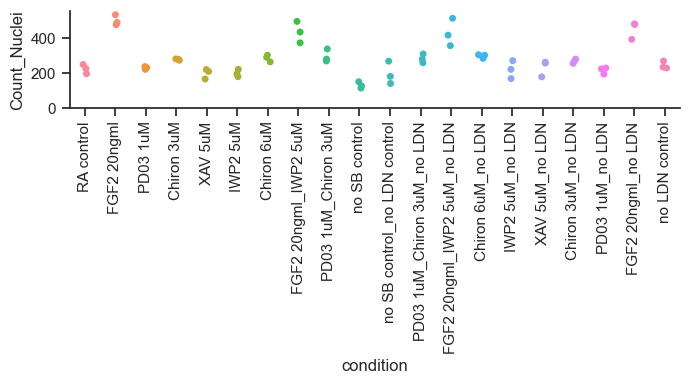

In [6]:
g = sns.catplot(data=imageinfo, y='Count_Nuclei', x='condition', height=1.6, aspect=4.5, legend=None)
g.set(ylim=(0, None))
g.set_xticklabels(rotation=90);

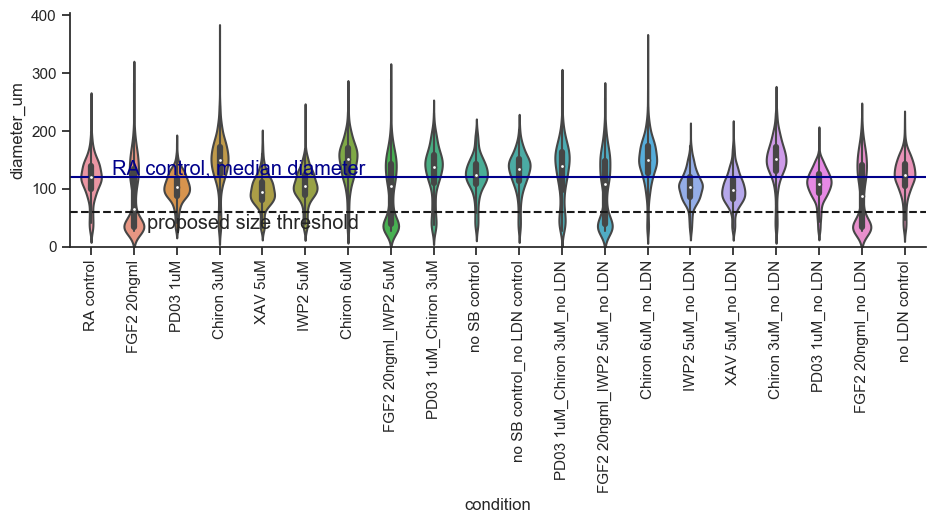

In [54]:
size_cutoff = 60
size_RAcontrolmedian = cysts[cysts.condition=='RA control']['diameter_um'].median()

g = sns.catplot(data=cysts, x='condition', y='diameter_um', height=3, aspect=3.2, width=0.6, kind='violin');
g.set(ylim=(0, None))
plt.axhline(size_cutoff, linestyle='--', color='k')
plt.axhline(size_RAcontrolmedian, linestyle='-', color='darkblue')
plt.text(0.5, 1.05*size_RAcontrolmedian, 'RA control, median diameter', color='darkblue', fontsize='large')
plt.text(1.3, 0.95*size_cutoff, 'proposed size threshold', fontsize='large', verticalalignment='top')
g.set_xticklabels(rotation=90);

Compared to RA control
- PD, XAV, IWP2 results in smaller cysts.
- CHIR 3 uM and 6 uM, noSB noLDN, results in larger cysts.
- FGF2, FGF2+IWP2 results in the morphological changes, and biomodal size distribution.

# filter out small cysts in all conditions and explore foxa2cluster properties

In [55]:
cysts2 = cysts[cysts['diameter_um'] > size_cutoff]

# recalculate fraction positive, fraction multi
cysts2 = cysts2.assign(foxa2pos = lambda x: x.Children_foxa2clusters_Count > 0)
cysts2 = cysts2.assign(foxa2multi = lambda x: x.Children_foxa2clusters_Count > 1)
imageinfo[['foxa2pos', 'foxa2multi']] = cysts2.groupby('ImageNumber')[['foxa2pos', 'foxa2multi']].mean()
imageinfo['count_cysts'] = cysts2.groupby('ImageNumber').size()

# area fraction of foxa2
cysts2 = cysts2.assign(foxa2_areafrac = lambda x: x.Children_foxa2clusters_Count*x.Mean_foxa2clusters_AreaShape_Area/x.AreaShape_Area)

# intensity fraction of foxa2 (integrated intensity of foxa2 normalized to that of DAPI)
cysts2 = cysts2.assign(foxa2_intfrac = lambda x: x.Children_foxa2clusters_Count*x.Mean_foxa2clusters_Intensity_IntegratedIntensity_OrigGreen/x.Intensity_IntegratedIntensity_OrigBlue)

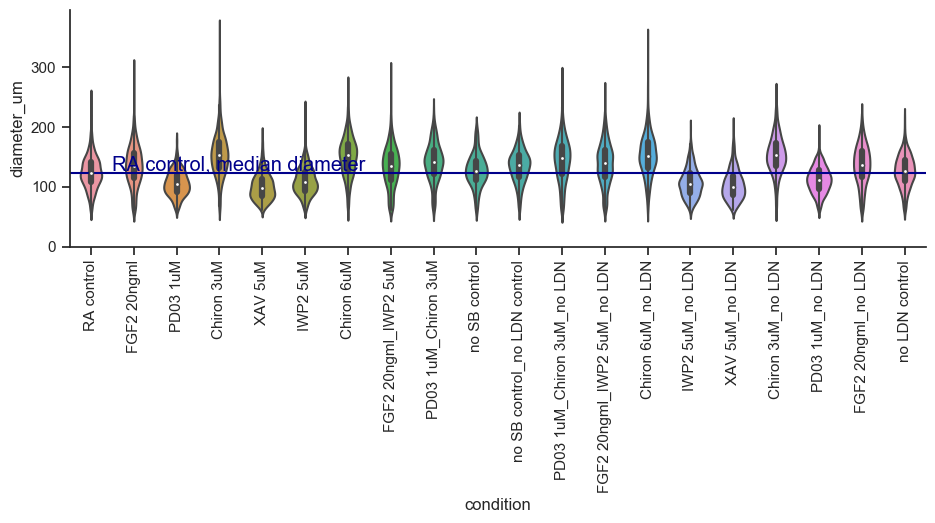

In [56]:
size_RAcontrolmedian = cysts2[cysts2.condition=='RA control']['diameter_um'].median()

g = sns.catplot(data=cysts2, x='condition', y='diameter_um', height=3, aspect=3.2, width=0.6, kind='violin');
g.set(ylim=(0, None))
plt.axhline(size_RAcontrolmedian, linestyle='-', color='darkblue')
plt.text(0.5, 1.05*size_RAcontrolmedian, 'RA control, median diameter', color='darkblue', fontsize='large')
g.set_xticklabels(rotation=90);

## plot results
* number of cysts per well (count_cysts)
* fraction of cysts with 1 or more clusters (foxa2pos)
* fraction of cysts with 2 or more clusters (foxa2multi)

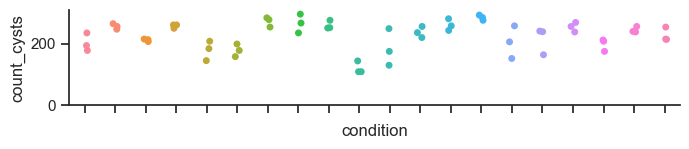

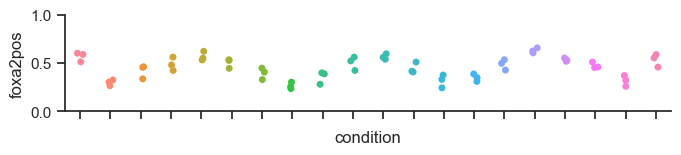

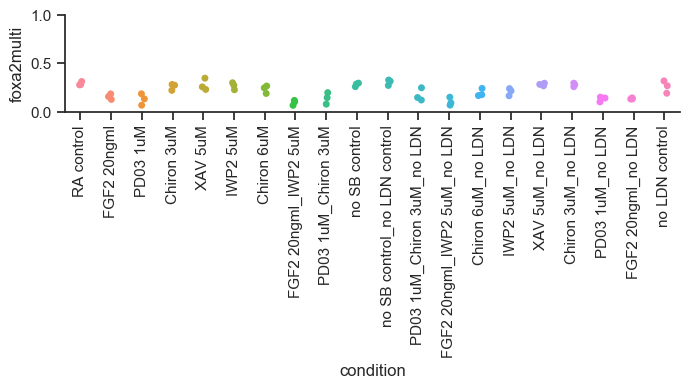

In [57]:
g = sns.catplot(data=imageinfo, y='count_cysts', x='condition', height=1.6, aspect=4.5, legend=None)
g.set(ylim=(0, None))
g.set(xticklabels=[]);

g = sns.catplot(data=imageinfo, y='foxa2pos', x='condition', height=1.6, aspect=4.5, legend=None)
g.set(ylim=(0, 1))
g.set(xticklabels=[]);

g = sns.catplot(data=imageinfo, y='foxa2multi', x='condition', height=1.6, aspect=4.5, legend=None)
g.set(ylim=(0, 1))
g.set_xticklabels(rotation=90);

## area fraction of foxa2 clusters relative to cyst

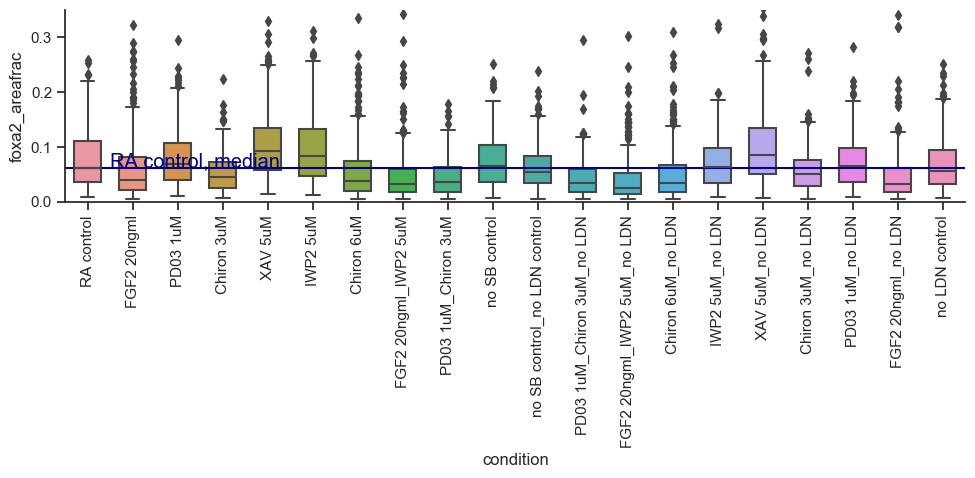

In [67]:
afrac_RAcontrolmedian = cysts2[cysts2.condition=='RA control']['foxa2_areafrac'].median()

g = sns.catplot(data=cysts2, x='condition', y='foxa2_areafrac', showfliers=True,
                height=5, aspect=2, width=0.6, kind='box');
g.set(ylim=(0, 0.35))
plt.axhline(afrac_RAcontrolmedian, linestyle='-', color='darkblue')
plt.text(0.5, 1.05*afrac_RAcontrolmedian, 'RA control, median', color='darkblue', fontsize='large')
g.set_xticklabels(rotation=90);

figname = 'summary-CP20210302-foxa2areafraction_allconds'
g.fig.tight_layout()
# plt.savefig(os.path.join(path_out, figname+'.pdf'), dpi=fig.dpi)

## integrated intensity of foxa2 clusters (Alexa488) normalized to  cyst (DAPI), arbitrary units

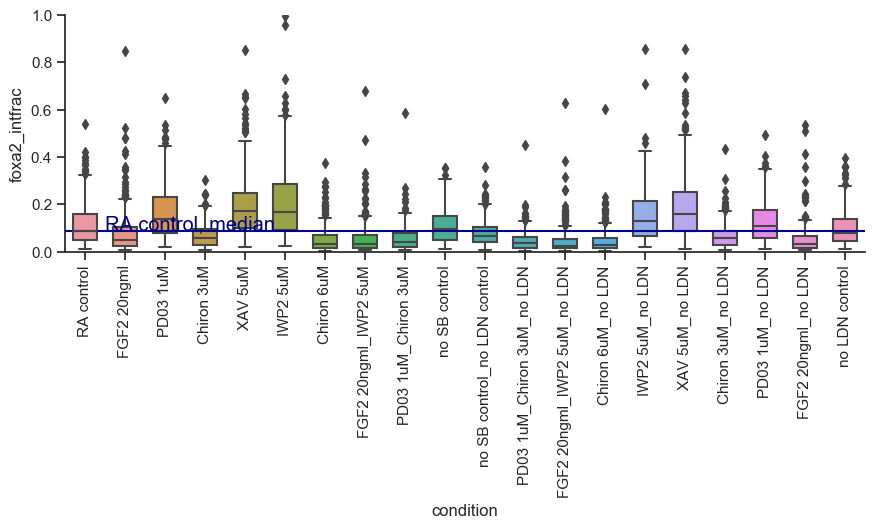

In [13]:
intfrac_RAcontrolmedian = cysts2[cysts2.condition=='RA control']['foxa2_intfrac'].median()

g = sns.catplot(data=cysts2, x='condition', y='foxa2_intfrac', height=3, aspect=3, width=0.6, kind='box');
g.set(ylim=(0, 1))
plt.axhline(intfrac_RAcontrolmedian, linestyle='-', color='darkblue')
plt.text(0.5, 1.05*intfrac_RAcontrolmedian, 'RA control, median', color='darkblue', fontsize='large')
g.set_xticklabels(rotation=90);

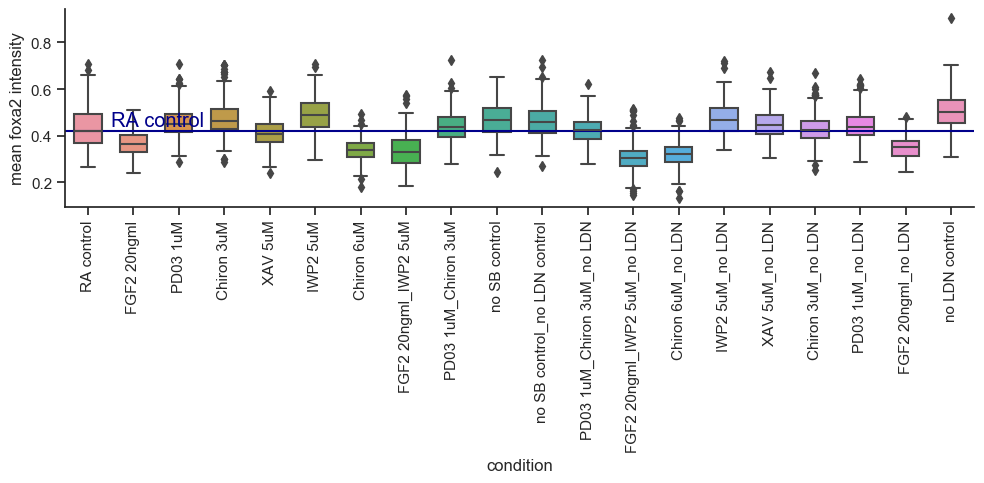

In [70]:
meanintfoxa2_RAcontrol = cysts2[cysts2.condition=='RA control']['Mean_foxa2clusters_Intensity_MeanIntensity_OrigGreen'].median()

g = sns.catplot(data=cysts2, x='condition', y='Mean_foxa2clusters_Intensity_MeanIntensity_OrigGreen', height=5, aspect=2, width=0.6, kind='box');
plt.axhline(meanintfoxa2_RAcontrol, linestyle='-', color='darkblue')
plt.text(0.5, 1.05*meanintfoxa2_RAcontrol, 'RA control', color='darkblue', fontsize='large')
plt.ylabel('mean foxa2 intensity')
g.set_xticklabels(rotation=90);

figname = 'summary-CP20210302-meanfoxa2intensity_allconds'
g.fig.tight_layout()
# plt.savefig(os.path.join(path_out, figname+'.pdf'), dpi=fig.dpi)

## Summary 2021.3.1

* Due to the sensitivity of imaging, FoxA2 positive fraction is not dramatically different across conditions. Perhaps, slight decrease with FGF2. We should follow up with ANOVA.
* Other metrics such as area fraction and intensity fraction show interesting trends.
* We could also look into shape metrics for foxa2 clusters, distance between clusters, but we should take a look at the Max Int Proj images first.


## Summary 2021.3.2

* After checking with Hannah, I made the thresholds more stringent for the foxa2 segmentation and re-ran CellProfiler.
* This shows a clear reduction of foxa2pos from 57% in RA control to 30% in FGF2.
* Foxa2 area fraction seems to be contain interesting info.
    * IWP2 and XAV increases foxa2 area fraciton.
    * CHIR, FGF reduces.
    * PD has no effect?

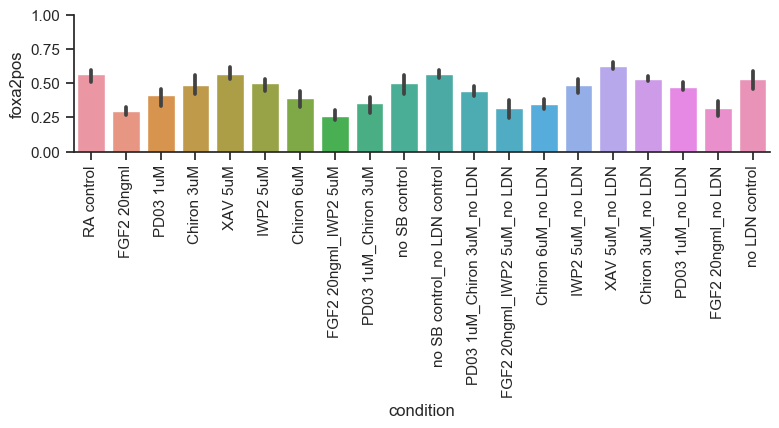

In [15]:
g = sns.catplot(data=imageinfo, y='foxa2pos', x='condition', height=2, aspect=4, legend=None, kind='bar')
g.set(ylim=(0, 1))
g.set_xticklabels(rotation=90);